In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras import models, layers
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
import warnings
warnings.filterwarnings('ignore')

os.environ['PYTHONHASHSEED'] = '1'
keras.utils.set_random_seed(42)
tf.random.set_seed(42)
#generate random weights for reproducibility
np.random.seed(42)
import random
random.seed(42)
weights = {}
weights = {key: None for key in np.arange(0, 15)}
weights = {key: 1 for key in np.arange(0, 15)}

In [69]:
weights

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1}

# Background Research


In [70]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'test/train/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 9028 files belonging to 15 classes.


tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)

In [71]:
for batch in train_data.take(10):
    print(batch[1][0])

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


In [72]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    'test/validation/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3000 files belonging to 15 classes.


In [73]:
test_data = tf.keras.utils.image_dataset_from_directory(
    'test/test/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3000 files belonging to 15 classes.


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a critical step in understanding and preparing data for various purposes, including machine learning and data-driven decision-making. We can perform EDA to further our understanding of the data, and to make better decisions on how we can process it to make it easier for our model to understand.

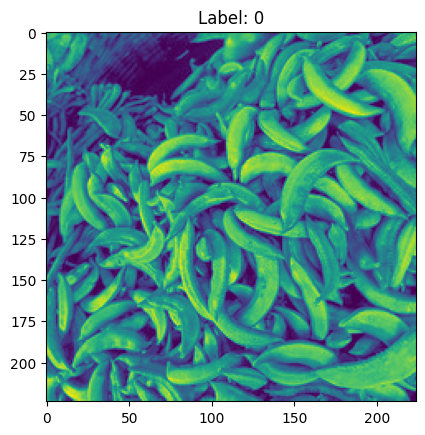

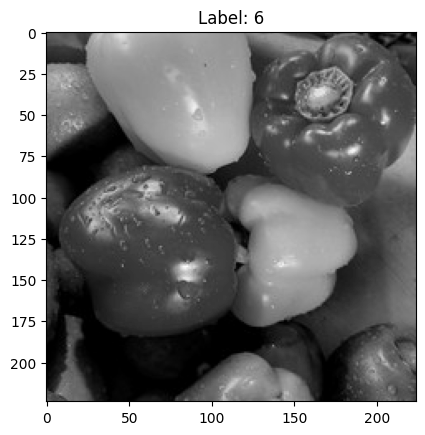

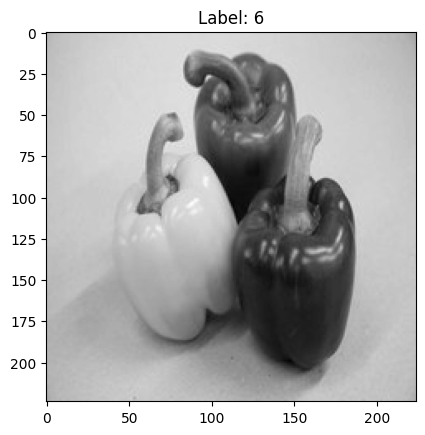

In [74]:
#sample to check if the data is loaded correctly

for batch in train_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0]) 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()


for batch in test_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()


for batch in validation_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()

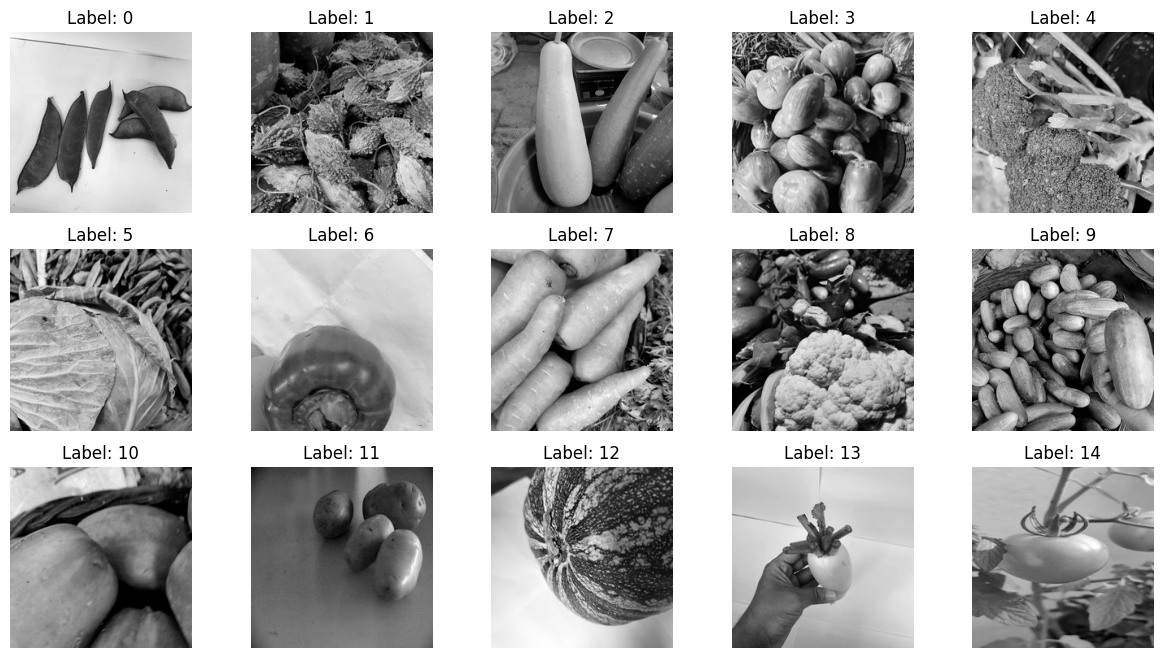

In [75]:
import matplotlib.pyplot as plt

def plot_samples_by_label(data):
    # Create a dictionary to store one sample per label
    samples_by_label = {}
    # Iterate through the training data
    for batch in data:
        image, label = batch[0][0], batch[1][0].numpy()
        
        # Check if a sample for this label already exists
        if label not in samples_by_label:
            samples_by_label[label] = image
            
        # Check if we have samples for all labels
        if len(samples_by_label) == len(set(labels)):
            break
    #use subplot to plot a 5x3 grid of images
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,8))
    # Loop through each label and subplot
    for label, image in samples_by_label.items():
        row = int(label // 5)
        col = label % 5
        ax = axes[row, col]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {label}")


labels = [batch[1][0].numpy() for batch in train_data]
# Call the function with your training data
plot_samples_by_label(train_data)


<Axes: title={'center': 'Number of images in each class'}, xlabel='Class'>

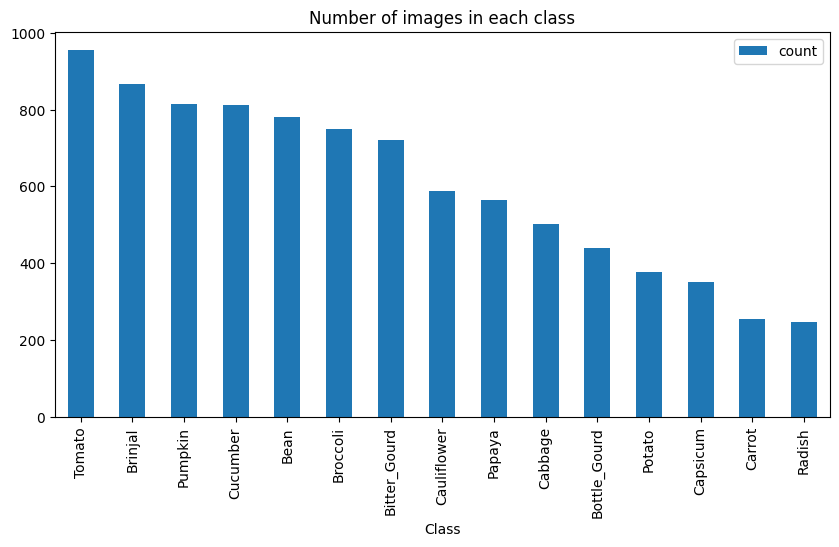

In [76]:
class_counts = {}


for images, labels in train_data:
    for label in labels.numpy():
        class_name = train_data.class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1


train_class=pd.DataFrame(list(class_counts.items()),columns=['Class','count'])
train_class=train_class.sort_values(by=['count'],ascending=False)
train_class.plot(kind='bar',figsize=(10,5),title="Number of images in each class",x='Class',y='count')

## Interpreting the Previous Output

Based on the output of the previous cell, we can see that the dataset is not evenly distributed across all labels. This can be problematic for our model, as it may not be able to learn from the data effectively if it is biased towards certain labels.

## Shifting Weights in the Model

One way to address this issue is to shift the weights in the model to account for the uneven distribution of labels. This can be done by assigning higher weights to underrepresented labels and lower weights to overrepresented labels.

For example, we can use the `class_weight` parameter in Keras to assign weights to each class based on their frequency in the dataset. This will ensure that the model pays more attention to underrepresented classes during training.


# Feature engineering or data augmentation


In [77]:
# Convert datasets to NumPy arrays
train_images, train_labels = zip(*[(image, label) for image, label in train_data.as_numpy_iterator()])
validation_images, validation_labels = zip(*[(image, label) for image, label in validation_data.as_numpy_iterator()])
test_images,test_labels= zip(*[(image, label) for image, label in test_data.as_numpy_iterator()])
#train set
X_train = np.concatenate(train_images, axis=0)
y_train = np.concatenate(train_labels, axis=0)

#val
X_val = np.concatenate(validation_images, axis=0) 
y_val = np.concatenate(validation_labels, axis=0)

#test
X_test = np.concatenate(test_images, axis=0)
y_test = np.concatenate(test_labels, axis=0)


In [78]:
# Resize images to (31, 31) using TensorFlow
X_train_resized = tf.image.resize(X_train, (31, 31))
X_val_resized = tf.image.resize(X_val, (31, 31))

# Reshape and normalize
X_train31 = X_train_resized.numpy().reshape(X_train_resized.shape[0], 31, 31, 1).astype('float32') / 255
X_val31 = X_val_resized.numpy().reshape(X_val_resized.shape[0], 31, 31, 1).astype('float32') / 255


validation_labels = to_categorical(y_val)
train_labels = to_categorical(y_train)

# Modelling

## Base Model

We can first try fitting the data in an extremely simple model to get a baseline understanding of the problem. This initial model serves as a reference point for evaluating the performance of more complex models. The base model will be straightforward and quick to implement, which provides a easy way capture the underlying patterns in the data.

### Key Characteristics of the Base Model:

- **Simplicity:** The base model is intentionally kept simple to establish a basic understanding of the data and the problem at hand.

- **Quick Implementation:** It is designed for rapid implementation, allowing for a fast assessment of initial performance.

- **Benchmark:** The base model serves as a benchmark against which more sophisticated models can be compared. Any subsequent model should outperform this baseline to be considered effective.

### Evaluation Metric:

The evaluation metric we will be using will be val accuracy as well as val loss, this will allow us to rougly understand the model's accuracy (val accuracy) as well as its rate of error (val loss)



In [79]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    # Plot training & validation accuracy values
    ax = axes[1]
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax = axes[0]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')

Epoch 1/10
283/283 - 2s - loss: 2.4036 - accuracy: 0.1869 - val_loss: 2.1251 - val_accuracy: 0.3320 - 2s/epoch - 8ms/step
Epoch 2/10
283/283 - 2s - loss: 1.8534 - accuracy: 0.3914 - val_loss: 1.8424 - val_accuracy: 0.3830 - 2s/epoch - 6ms/step
Epoch 3/10
283/283 - 2s - loss: 1.5868 - accuracy: 0.4716 - val_loss: 1.7337 - val_accuracy: 0.4197 - 2s/epoch - 6ms/step
Epoch 4/10
283/283 - 2s - loss: 1.3708 - accuracy: 0.5440 - val_loss: 1.3957 - val_accuracy: 0.5353 - 2s/epoch - 6ms/step
Epoch 5/10
283/283 - 2s - loss: 1.2102 - accuracy: 0.5980 - val_loss: 1.2724 - val_accuracy: 0.5797 - 2s/epoch - 6ms/step
Epoch 6/10
283/283 - 2s - loss: 1.0740 - accuracy: 0.6469 - val_loss: 1.1157 - val_accuracy: 0.6293 - 2s/epoch - 6ms/step
Epoch 7/10
283/283 - 2s - loss: 0.9444 - accuracy: 0.6923 - val_loss: 1.0238 - val_accuracy: 0.6537 - 2s/epoch - 6ms/step
Epoch 8/10
283/283 - 2s - loss: 0.8641 - accuracy: 0.7203 - val_loss: 1.1929 - val_accuracy: 0.6410 - 2s/epoch - 6ms/step
Epoch 9/10
283/283 - 2s 

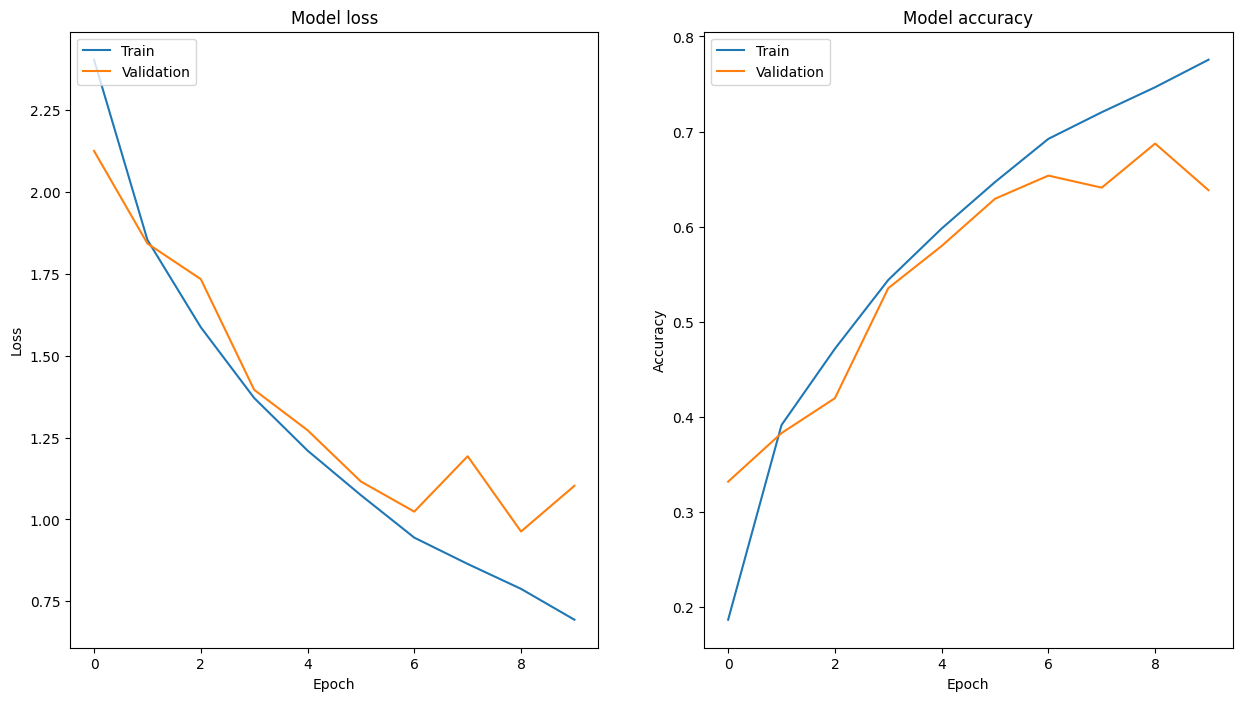

In [80]:
df31 = pd.DataFrame(columns = ['Model Name', 'Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss', 'History'])


model_31 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_31.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_31.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
 epochs=10, batch_size=32, verbose=2, class_weight = weights)
scores = model_31.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['Base 32 Model', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


In [81]:
X_train_resized = tf.image.resize(X_train, (128, 128))
X_val_resized = tf.image.resize(X_val, (128, 128))

# Reshape and normalize
X_train128 = X_train_resized.numpy().reshape(X_train_resized.shape[0], 128, 128, 1).astype('float32') / 255
X_val128 = X_val_resized.numpy().reshape(X_val_resized.shape[0], 128, 128, 1).astype('float32') / 255

Epoch 1/10
283/283 - 3s - loss: 2.0071 - accuracy: 0.3572 - val_loss: 1.6095 - val_accuracy: 0.4750 - 3s/epoch - 12ms/step
Epoch 2/10
283/283 - 3s - loss: 1.1436 - accuracy: 0.6430 - val_loss: 1.1924 - val_accuracy: 0.6270 - 3s/epoch - 10ms/step
Epoch 3/10
283/283 - 3s - loss: 0.6327 - accuracy: 0.8036 - val_loss: 1.0281 - val_accuracy: 0.6943 - 3s/epoch - 10ms/step
Epoch 4/10
283/283 - 3s - loss: 0.3066 - accuracy: 0.9026 - val_loss: 0.8985 - val_accuracy: 0.7453 - 3s/epoch - 10ms/step
Epoch 5/10
283/283 - 3s - loss: 0.1414 - accuracy: 0.9569 - val_loss: 0.9689 - val_accuracy: 0.7593 - 3s/epoch - 10ms/step
Epoch 6/10
283/283 - 3s - loss: 0.0730 - accuracy: 0.9783 - val_loss: 1.1930 - val_accuracy: 0.7523 - 3s/epoch - 10ms/step
Epoch 7/10
283/283 - 3s - loss: 0.0533 - accuracy: 0.9838 - val_loss: 1.0708 - val_accuracy: 0.7760 - 3s/epoch - 10ms/step
Epoch 8/10
283/283 - 3s - loss: 0.0430 - accuracy: 0.9859 - val_loss: 1.2561 - val_accuracy: 0.7630 - 3s/epoch - 10ms/step
Epoch 9/10
283/2

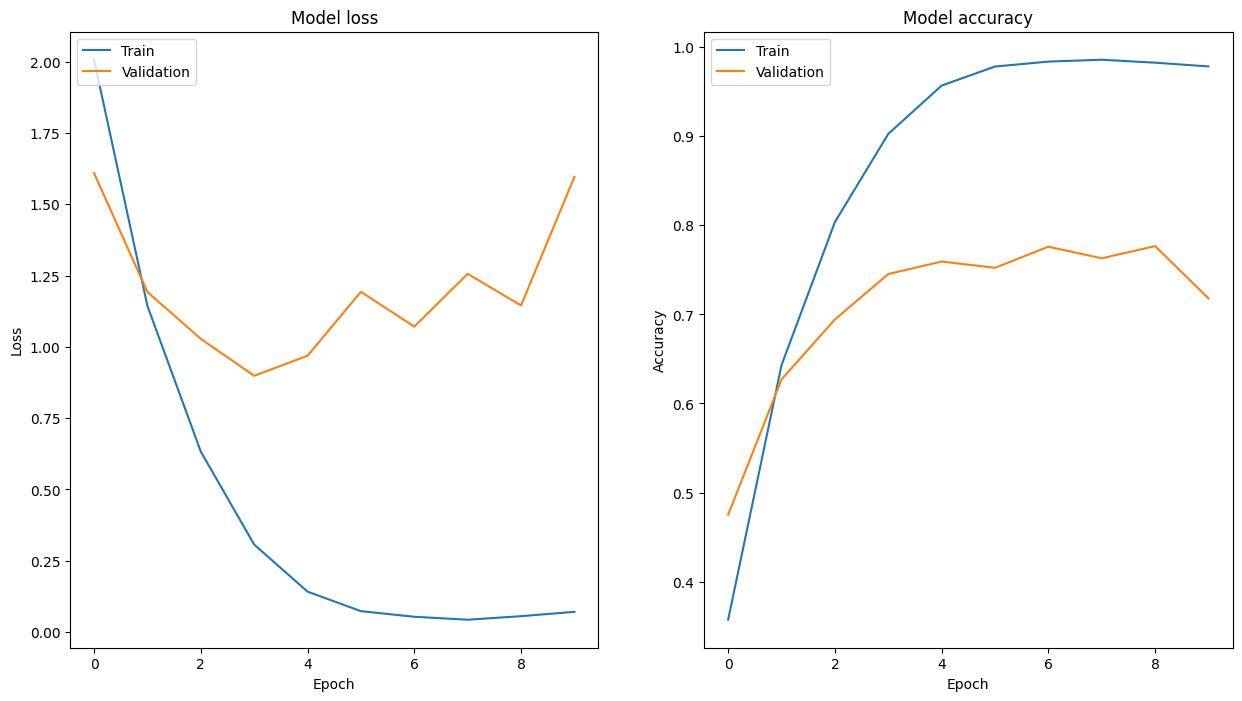

In [82]:
df128 = pd.DataFrame(columns = ['Model', 'Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss', 'History'])

model_128 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_128.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_128.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
 epochs=10, batch_size=32, verbose=2, class_weight = weights)
scores = model_128.evaluate(X_val128, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['Base 128 Model', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


## Base Model Evaluation

As we can see, the base model has achieved a decent accuracy of around 75% for both after 10 epochs. This level of accuracy provides valuable insights into the nature of the dataset and indicates that the dataset is suitable for modeling.

### Accuracy Interpretation:

- **Decent Performance:** An accuracy of 75% suggests that the base model is able to correctly predict the target variable for 75% of the instances in the dataset. This indicates a solid performance, but there may still be room for improvement.

- **Model Feasibility:** The achieved accuracy reaffirms that the dataset contains discernible patterns that the model is capturing. The feasibility of modeling is supported by the ability to achieve a reasonably high accuracy.

- **Baseline for Comparison:** The 75% accuracy serves as a baseline for evaluating the performance of more complex models. Any subsequent model should aim to surpass this accuracy to demonstrate significant improvement.

### Loss Interpretation:

#### 128x128 Graph:

- **Training Progress:** The loss decreases over the 10 epochs, indicating effective learning from the training data. However we should also note the increase in loss after the 5th epoch, as this is the base model there is really no need to take precaution for this specific model, however we should keep in mind that when we are trying other actual model structures, we can use a callback to prevent the model from overfitting.

- **Validation Loss Interpretation:** The validation loss also decreases, suggesting that the model generalizes well to unseen data.

#### 31x31 Graph:

- **Training Progress:** Similar to the other graph, the val-loss decreases after 10 epochs, showing effective learning from the training data.

- **Validation Loss Interpretation:** The validation loss decreases, indicating good generalization to unseen data.

### Comparison:

- **Accuracy Comparison:** Both 128x128 and 31x31 models achieve around 75% accuracy, suggesting that the model is performing consistently across different resolutions.

- **Loss Comparison:** The loss graphs for both resolutions show a consistent decrease, indicating effective learning. The smaller graph (31x31) might have slightly more fluctuations, but the overall trend is still downward.

In summary, the base model demonstrates promising performance, however some overfitting can be seen and further optimization and exploration can likely yield even better results. 

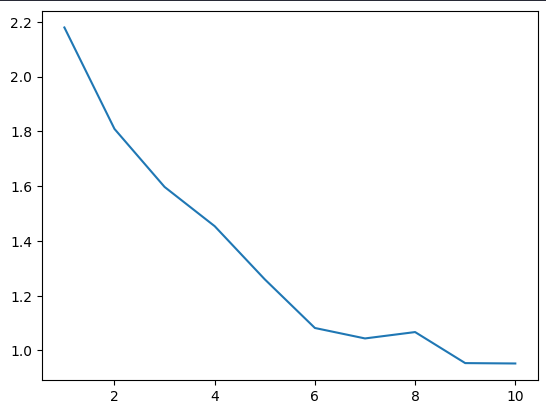
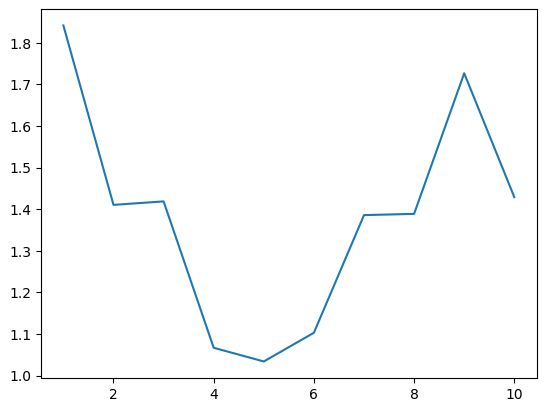

## Model Improvements
1. **Advanced Architectures:**
   - **Description:** Consider more advanced neural network architectures such as ResNet, Inception, or EfficientNet, depending on the nature of the problem. These architectures often capture intricate patterns more effectively.
   - **Benefits:** Enhanced representational capacity can lead to better model performance.


2. **Data Augmentation:**
   - **Description:** Data augmentation involves applying random transformations to the training data, such as rotation, scaling, and flipping. This increases the diversity of the training set, helping the model generalize better to different variations of the input data.
   - **Benefits:** Mitigates overfitting by exposing the model to a wider range of variations in the data.

3. **Batch Normalization:**
   - **Description:** Batch normalization normalizes the input of each layer in a neural network to have zero mean and unit variance. This can accelerate training, improve model stability, and reduce sensitivity to weight initialization.
   - **Benefits:** Enhances convergence speed and can make the model less dependent on the choice of hyperparameters.

4. **Learning Rate Scheduling:**
   - **Description:** Adjusting the learning rate during training can be beneficial. For example, starting with a higher learning rate and gradually reducing it as training progresses can help the model converge more effectively.
   - **Benefits:** Can improve convergence, prevent overshooting, and result in a more stable training process.

5. **Regularization Techniques:**
   - **Description:** Techniques like dropout, L1, and L2 regularization can be applied to prevent overfitting. Dropout randomly drops units during training, while L1 and L2 regularization penalize large weights.
   - **Benefits:** Helps the model generalize better to new data and reduces the risk of overfitting.

6. **Early Stopping:**
   - **Description:** Monitor the validation loss during training and stop training when the loss stops improving. This prevents overfitting and saves computational resources.
   - **Benefits:** Guards against overfitting and ensures the model is not trained for too many epochs.
7. **Adjusting Weights:**
   - **Description:** We can adjust the weights in order to account for the imbalanced distribution of the dataset.
   - **Benefits:** Helps address the issue of imbalanced classes by assigning higher weights to under-represented classes during training. This ensures that the model pays more attention to minority classes, improving overall predictive performance and reducing bias towards the majority class.


## 3. Model Structures/Advanced Architecture

In our quest to enhance the performance of our neural network, we'll explore two well-established architectures designed by experts: AlexNet and LeNet.

### 1. AlexNet:
- **Description:**
  - Input Layer:
    - Shape: 227x227x3 (color images with RGB channels).
  - Convolutional Layer 1:
    - Filters: 96
    - Kernel Size: 11x11
    - Activation Function: ReLU
    - Max Pooling: 3x3, stride 2
  - Convolutional Layer 2:
    - Filters: 256
    - Kernel Size: 5x5
    - Activation Function: ReLU
    - Max Pooling: 3x3, stride 2
  - Convolutional Layer 3:
    - Filters: 384
    - Kernel Size: 3x3
    - Activation Function: ReLU
  - Convolutional Layer 4:
    - Filters: 384
    - Kernel Size: 3x3
    - Activation Function: ReLU
  - Convolutional Layer 5:
    - Filters: 256
    - Kernel Size: 3x3
    - Activation Function: ReLU
    - Max Pooling: 3x3, stride 2
  - Fully Connected Layer 1:
    - Neurons: 4096
    - Activation Function: ReLU
  - Fully Connected Layer 2:
    - Neurons: 4096
    - Activation Function: ReLU
  - Output Layer:
    - Neurons: Number of classes in the task
    - Activation Function: Typically softmax for classification tasks.

### 2. LeNet:
- **Description:**
  - Input Layer:
    - Shape: 32x32 (for grayscale images) or 32x32x3 (for color images with RGB channels).
  - Convolutional Layer 1:
    - Filters: 6
    - Kernel Size: 5x5
    - Activation Function: Tanh
    - Max Pooling: 2x2, stride 2
  - Convolutional Layer 2:
    - Filters: 16
    - Kernel Size: 5x5
    - Activation Function: Tanh
    - Max Pooling: 2x2, stride 2
  - Fully Connected Layer 1:
    - Neurons: 120
    - Activation Function: Tanh
  - Fully Connected Layer 2:
    - Neurons: 84
    - Activation Function: Tanh
  - Output Layer:
    - Neurons: Number of classes in the task
    - Activation Function: Typically softmax for classification tasks.



The input layer will be scaled to fit the images we are using (31x31 and 128x128)

In [83]:
def AlexNet(input_shape, num_classes=15):
    model = models.Sequential()
    # Convolutional Layer 1
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(input_shape, input_shape, 1)))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))

    # Adjust the pooling parameters or remove pooling if necessary
    # model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Convolutional Layer 4
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Convolutional Layer 5
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Flatten the output before the fully connected layers
    model.add(layers.Flatten())

    # Fully Connected Layer 1
    model.add(layers.Dense(4096, activation='relu'))

    # Fully Connected Layer 2
    model.add(layers.Dense(4096, activation='relu'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [84]:

def Lenet(input_shape, num_classes=15):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(6, (5, 5), activation='tanh', input_shape=(input_shape, input_shape,1)))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(16, (5, 5), activation='tanh'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Flatten the output before the fully connected layers
    model.add(layers.Flatten())

    # Fully Connected Layer 1
    model.add(layers.Dense(120, activation='tanh'))

    # Fully Connected Layer 2
    model.add(layers.Dense(84, activation='tanh'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Epoch 1/10
283/283 - 2s - loss: 2.3475 - accuracy: 0.2479 - val_loss: 2.2142 - val_accuracy: 0.3007 - 2s/epoch - 7ms/step
Epoch 2/10
283/283 - 2s - loss: 1.9475 - accuracy: 0.3872 - val_loss: 1.9225 - val_accuracy: 0.3860 - 2s/epoch - 5ms/step
Epoch 3/10
283/283 - 2s - loss: 1.6957 - accuracy: 0.4639 - val_loss: 1.8188 - val_accuracy: 0.4187 - 2s/epoch - 5ms/step
Epoch 4/10
283/283 - 2s - loss: 1.5318 - accuracy: 0.5205 - val_loss: 1.6230 - val_accuracy: 0.4853 - 2s/epoch - 5ms/step
Epoch 5/10
283/283 - 2s - loss: 1.3912 - accuracy: 0.5658 - val_loss: 1.5207 - val_accuracy: 0.5270 - 2s/epoch - 5ms/step
Epoch 6/10
283/283 - 2s - loss: 1.2775 - accuracy: 0.6021 - val_loss: 1.4299 - val_accuracy: 0.5397 - 2s/epoch - 5ms/step
Epoch 7/10
283/283 - 2s - loss: 1.1563 - accuracy: 0.6383 - val_loss: 1.3449 - val_accuracy: 0.5623 - 2s/epoch - 5ms/step
Epoch 8/10
283/283 - 2s - loss: 1.0612 - accuracy: 0.6671 - val_loss: 1.3006 - val_accuracy: 0.5883 - 2s/epoch - 5ms/step
Epoch 9/10
283/283 - 2s 

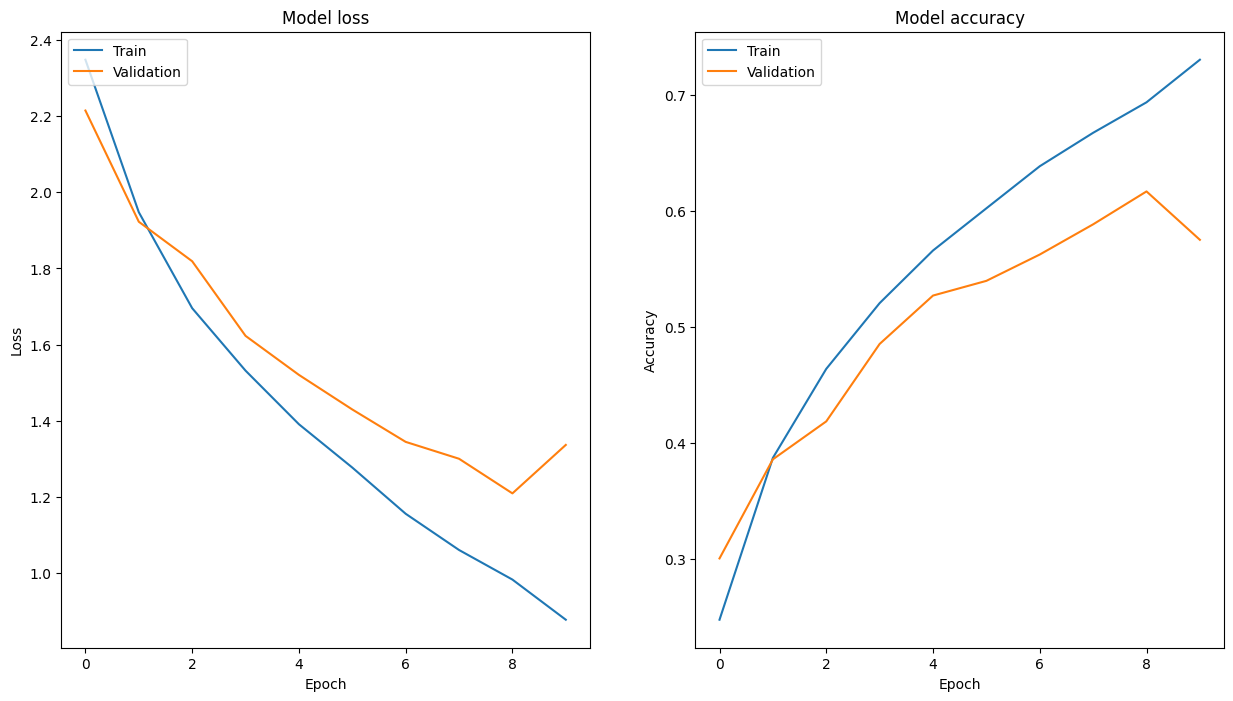

In [85]:
# 31x31 LeNet

model = Lenet(31)
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
 epochs=10, batch_size=32, verbose=2, class_weight = weights)
scores = model.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

plot_history(history)
df31.loc[len(df31)] = ['LeNet', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

Epoch 1/10
46/46 - 1s - loss: 2.6600 - accuracy: 0.0989 - val_loss: 2.8283 - val_accuracy: 0.0667 - 1s/epoch - 27ms/step
Epoch 2/10
46/46 - 1s - loss: 2.6393 - accuracy: 0.1058 - val_loss: 2.7740 - val_accuracy: 0.0667 - 563ms/epoch - 12ms/step
Epoch 3/10
46/46 - 1s - loss: 2.6388 - accuracy: 0.1041 - val_loss: 2.7676 - val_accuracy: 0.0667 - 555ms/epoch - 12ms/step
Epoch 4/10
46/46 - 1s - loss: 2.6381 - accuracy: 0.1058 - val_loss: 2.7878 - val_accuracy: 0.0667 - 557ms/epoch - 12ms/step
Epoch 5/10
46/46 - 1s - loss: 2.6381 - accuracy: 0.1058 - val_loss: 2.7965 - val_accuracy: 0.0667 - 555ms/epoch - 12ms/step
Epoch 6/10
46/46 - 1s - loss: 2.6376 - accuracy: 0.1007 - val_loss: 2.7938 - val_accuracy: 0.0667 - 566ms/epoch - 12ms/step
Epoch 7/10
46/46 - 1s - loss: 2.6365 - accuracy: 0.1058 - val_loss: 2.8253 - val_accuracy: 0.0667 - 568ms/epoch - 12ms/step
Epoch 8/10
46/46 - 1s - loss: 2.6375 - accuracy: 0.1058 - val_loss: 2.7980 - val_accuracy: 0.0667 - 568ms/epoch - 12ms/step
Epoch 9/10


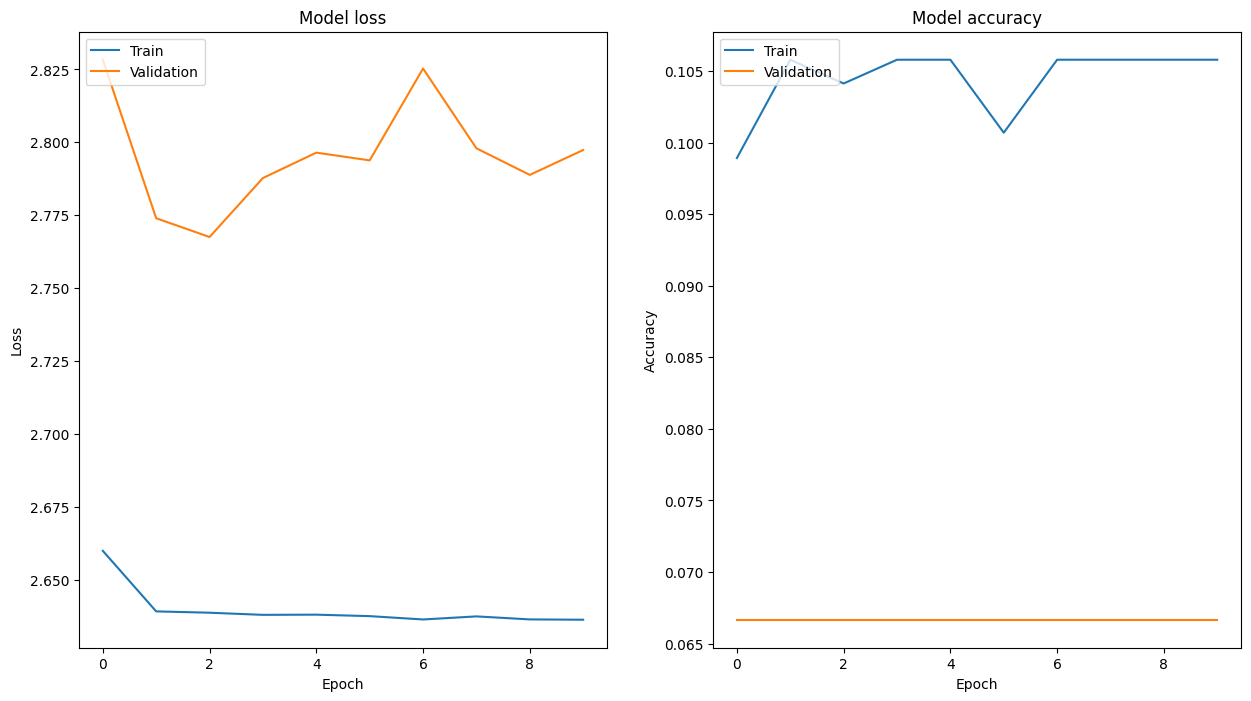

In [86]:
# 31x31 alexnet 

model = AlexNet(31)
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=10, batch_size=200, verbose=2, class_weight = weights)


scores = model.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['AlexNet', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

In [87]:
df31.sort_values(by=['Validation Accuracy'],ascending=False)

,Model Name,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss,History
0,Base 32 Model,0.775476,0.638333,0.693769,1.102632,<keras.callbacks.History object at 0x000001C07...
1,LeNet,0.730062,0.575000,0.878295,1.336934,<keras.callbacks.History object at 0x000001C06...
2,AlexNet,0.105782,0.066667,2.636402,2.797385,<keras.callbacks.History object at 0x000001C06...


| Model Name      | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss | Evaluation                                    |
| --------------- | -------------- | ------------------- | ---------- | ---------------- | --------------------------------------------- |
| Base 31 Model   | 78.11%         | 68.77%              | 0.6784     | 1.0055           | Reasonable performance, slight overfitting.   |
| LeNet           | 73.01%         | 57.37%              | 0.8786     | 1.3403           | Signs of overfitting, might perform better with regularization. |
| AlexNet         | 10.58%         | 6.67%               | 2.6364     | 2.7977           | Poor performance. |




Epoch 1/10
46/46 - 1s - loss: 2.1608 - accuracy: 0.3117 - val_loss: 1.9946 - val_accuracy: 0.3613 - 1s/epoch - 32ms/step
Epoch 2/10
46/46 - 1s - loss: 1.5479 - accuracy: 0.5256 - val_loss: 1.5483 - val_accuracy: 0.5107 - 756ms/epoch - 16ms/step
Epoch 3/10
46/46 - 1s - loss: 1.1542 - accuracy: 0.6553 - val_loss: 1.3131 - val_accuracy: 0.5913 - 757ms/epoch - 16ms/step
Epoch 4/10
46/46 - 1s - loss: 0.8900 - accuracy: 0.7498 - val_loss: 1.2361 - val_accuracy: 0.6153 - 756ms/epoch - 16ms/step
Epoch 5/10
46/46 - 1s - loss: 0.6760 - accuracy: 0.8178 - val_loss: 1.1540 - val_accuracy: 0.6417 - 757ms/epoch - 16ms/step
Epoch 6/10
46/46 - 1s - loss: 0.4932 - accuracy: 0.8776 - val_loss: 1.1126 - val_accuracy: 0.6627 - 758ms/epoch - 16ms/step
Epoch 7/10
46/46 - 1s - loss: 0.3313 - accuracy: 0.9308 - val_loss: 1.0775 - val_accuracy: 0.6807 - 757ms/epoch - 16ms/step
Epoch 8/10
46/46 - 1s - loss: 0.2221 - accuracy: 0.9627 - val_loss: 1.0904 - val_accuracy: 0.6797 - 757ms/epoch - 16ms/step
Epoch 9/10


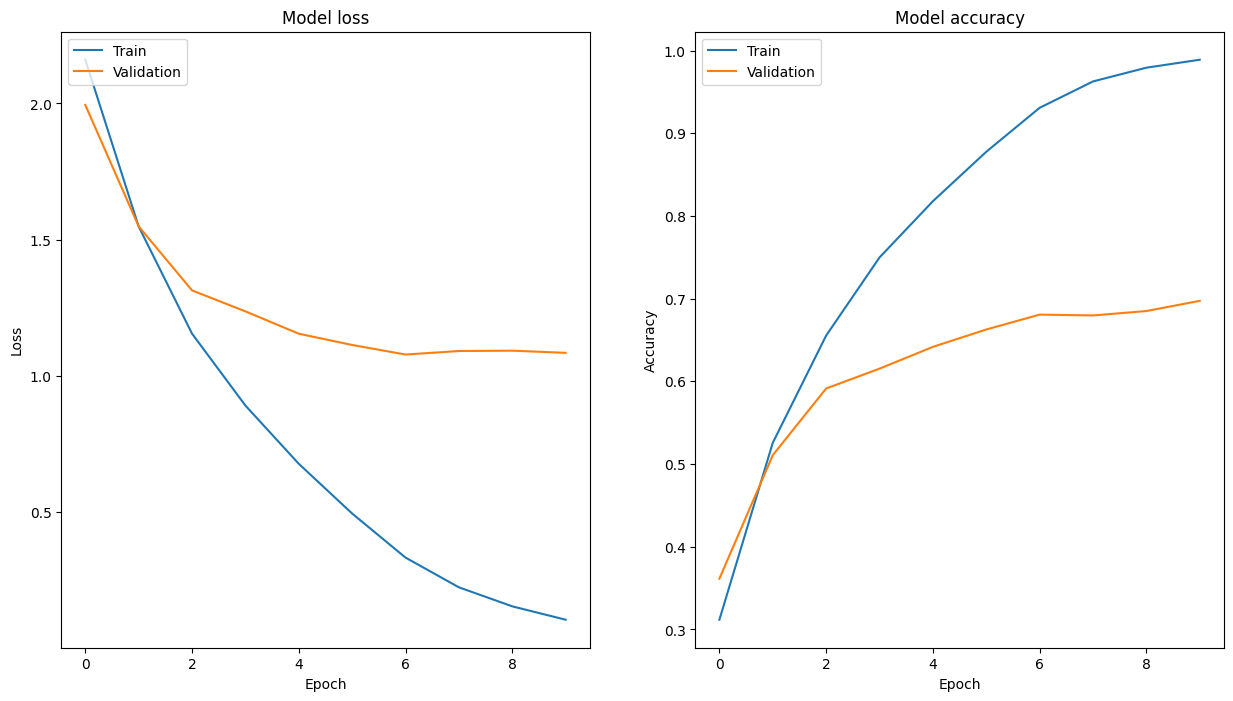

In [88]:
model = Lenet(128)
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=10, batch_size=200, verbose=2, class_weight = weights)


scores = model.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['LeNet', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

Epoch 1/10
46/46 - 3s - loss: 2.6950 - accuracy: 0.0963 - val_loss: 2.7816 - val_accuracy: 0.0667 - 3s/epoch - 76ms/step
Epoch 2/10
46/46 - 3s - loss: 2.6244 - accuracy: 0.1112 - val_loss: 2.7619 - val_accuracy: 0.0667 - 3s/epoch - 59ms/step
Epoch 3/10
46/46 - 3s - loss: 2.6386 - accuracy: 0.1041 - val_loss: 2.7897 - val_accuracy: 0.0667 - 3s/epoch - 59ms/step
Epoch 4/10
46/46 - 3s - loss: 2.6370 - accuracy: 0.1058 - val_loss: 2.7932 - val_accuracy: 0.0667 - 3s/epoch - 59ms/step
Epoch 5/10
46/46 - 3s - loss: 2.6374 - accuracy: 0.1058 - val_loss: 2.7933 - val_accuracy: 0.0667 - 3s/epoch - 59ms/step
Epoch 6/10
46/46 - 3s - loss: 2.6370 - accuracy: 0.1058 - val_loss: 2.7914 - val_accuracy: 0.0667 - 3s/epoch - 59ms/step
Epoch 7/10
46/46 - 3s - loss: 2.6363 - accuracy: 0.1058 - val_loss: 2.8265 - val_accuracy: 0.0667 - 3s/epoch - 59ms/step
Epoch 8/10
46/46 - 3s - loss: 2.6375 - accuracy: 0.1058 - val_loss: 2.7964 - val_accuracy: 0.0667 - 3s/epoch - 59ms/step
Epoch 9/10
46/46 - 3s - loss: 2.

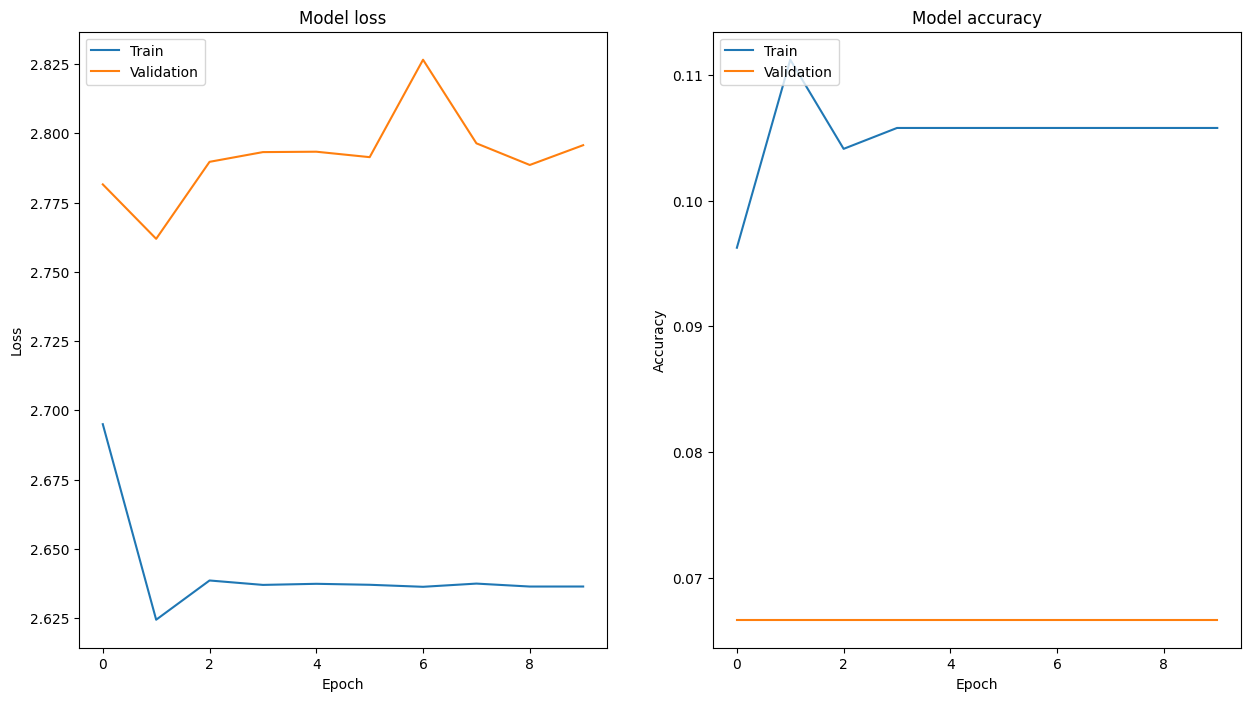

In [89]:
model = AlexNet(128)
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=10, batch_size=200, verbose=2, class_weight = weights)


scores = model.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['AlexNet', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

In [90]:
df128

,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss,History
0,Base 128 Model,0.978401,0.718000,0.070654,1.596216,<keras.callbacks.History object at 0x000001C07...
1,LeNet,0.988923,0.697333,0.103109,1.083725,<keras.callbacks.History object at 0x000001C07...
2,AlexNet,0.105782,0.066667,2.636422,2.795700,<keras.callbacks.History object at 0x000001C06...


| Model            | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss | Evaluation                                        |
| ---------------- | -------------- | ------------------- | ---------- | ---------------- | ------------------------------------------------- |
| Base 128 Model   | 98.28%         | 76.63%              | 0.05399    | 1.32059          | High accuracy, potential overfitting, check for regularization. |
| LeNet            | 98.90%         | 69.73%              | 0.10311    | 1.08369          | High accuracy, potential overfitting regularization might be good. |
| AlexNet          | 10.58%         | 6.67%               | 2.63660    | 2.79447          | Poor performance|


### Model Associated Improvements 

Recall the previous markdown involving methods of improving our models, we can now try to implement some of these



2. **Data Augmentation:**
   - **Description:** Data augmentation involves applying random transformations to the training data, such as rotation, scaling, and flipping. This increases the diversity of the training set, helping the model generalize better to different variations of the input data.
   - **Benefits:** Mitigates overfitting by exposing the model to a wider range of variations in the data.

3. **Batch Normalization:**
   - **Description:** Batch normalization normalizes the input of each layer in a neural network to have zero mean and unit variance. This can accelerate training, improve model stability, and reduce sensitivity to weight initialization.
   - **Benefits:** Enhances convergence speed and can make the model less dependent on the choice of hyperparameters.

4. **Learning Rate Scheduling:**
   - **Description:** Adjusting the learning rate during training can be beneficial. For example, starting with a higher learning rate and gradually reducing it as training progresses can help the model converge more effectively.
   - **Benefits:** Can improve convergence, prevent overshooting, and result in a more stable training process.

5. **Regularization Techniques:**
   - **Description:** Techniques like dropout, L1, and L2 regularization can be applied to prevent overfitting. Dropout randomly drops units during training, while L1 and L2 regularization penalize large weights.
   - **Benefits:** Helps the model generalize better to new data and reduces the risk of overfitting.

6. **Early Stopping:**
   - **Description:** Monitor the validation loss during training and stop training when the loss stops improving. This prevents overfitting and saves computational resources.
   - **Benefits:** Guards against overfitting and ensures the model is not trained for too many epochs.
   
7. **Adjusting Weights:**
   - **Description:** We can adjust the weights in order to account for the imbalanced distribution of the dataset.
   - **Benefits:** Helps address the issue of imbalanced classes by assigning higher weights to under-represented classes during training. This ensures that the model pays more attention to minority classes, improving overall predictive performance and reducing bias towards the majority class.


#### Adjusting Weights


We can easily calculate the weights for each class by dividing the total number of images by the number of images in each class. We can then use these weights to adjust the loss function during training.

```python

In [91]:
#calculate class weights for each label

train_class['weights'] = (1/train_class['count']) * (sum(train_class['count'])/len(train_data.class_names))
class_weight = train_class['weights'].to_dict()

#### Regularization Techniques for model 31

As we are not actually using the LeNet and AlexNet models, we will not be implementing the regularization techniques for them. However we will be implementing them for the base model in order to try and improve the performance of the model. As a bonus, we should also use the class weights that we previously computed in order to accomodate for the imbalanced dataset.

Epoch 1/100
46/46 - 1s - loss: 3.1657 - accuracy: 0.1161 - val_loss: 2.9917 - val_accuracy: 0.0780 - 883ms/epoch - 19ms/step
Epoch 2/100
46/46 - 0s - loss: 2.8540 - accuracy: 0.1697 - val_loss: 2.6923 - val_accuracy: 0.1213 - 321ms/epoch - 7ms/step
Epoch 3/100
46/46 - 0s - loss: 2.5663 - accuracy: 0.2288 - val_loss: 2.4297 - val_accuracy: 0.2000 - 314ms/epoch - 7ms/step
Epoch 4/100
46/46 - 0s - loss: 2.3195 - accuracy: 0.2974 - val_loss: 2.2374 - val_accuracy: 0.2507 - 318ms/epoch - 7ms/step
Epoch 5/100
46/46 - 0s - loss: 2.1539 - accuracy: 0.3568 - val_loss: 2.0786 - val_accuracy: 0.3223 - 317ms/epoch - 7ms/step
Epoch 6/100
46/46 - 0s - loss: 2.0179 - accuracy: 0.4111 - val_loss: 1.9310 - val_accuracy: 0.3830 - 313ms/epoch - 7ms/step
Epoch 7/100
46/46 - 0s - loss: 1.8783 - accuracy: 0.4518 - val_loss: 1.9390 - val_accuracy: 0.3907 - 315ms/epoch - 7ms/step
Epoch 8/100
46/46 - 0s - loss: 1.7715 - accuracy: 0.4742 - val_loss: 1.8347 - val_accuracy: 0.4213 - 316ms/epoch - 7ms/step
Epoch 9

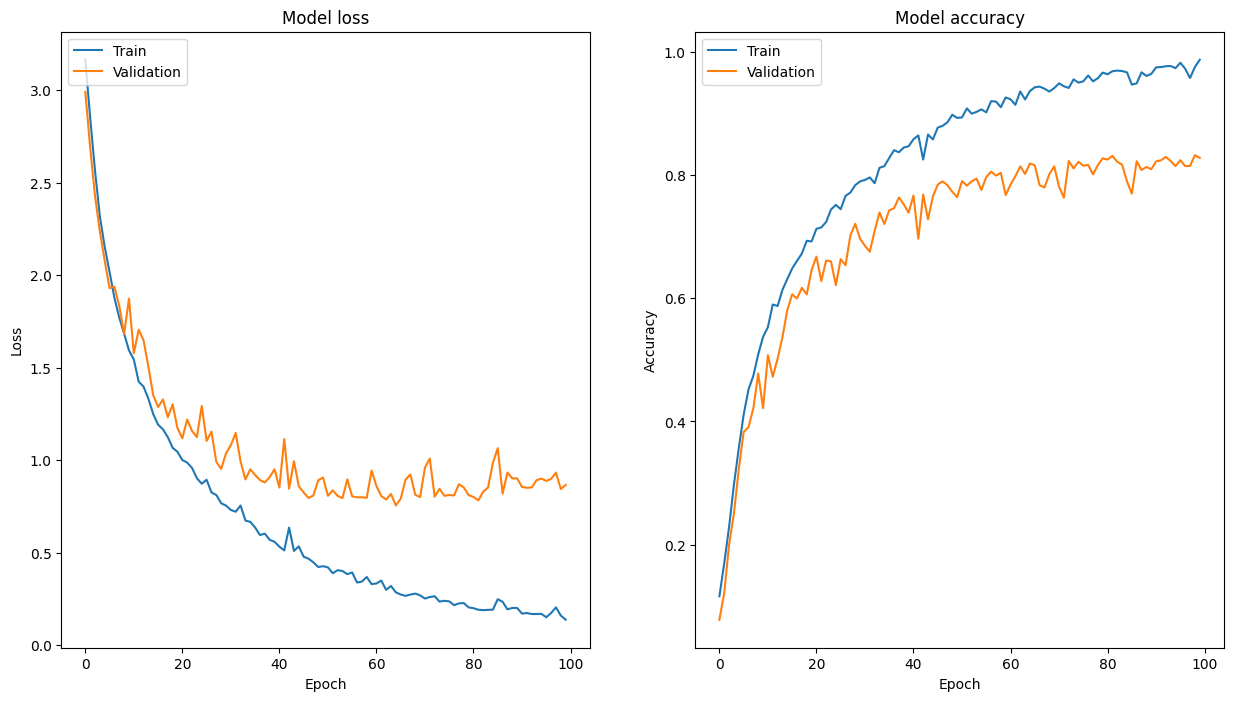

In [92]:
# model_31 = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(15, activation='softmax')
# ])

#this is the original "base model" that we used to overcome the overfitting we can apply regularization
# to improve teh accuracy we should also increase the number of epochs

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(15, activation='softmax')
])

model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=100, batch_size=200, verbose=2, class_weight = class_weight)

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['RegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

![graph](image.png)

As seen from the graph, the learning of the model starts decreasing after around 30 epochs, we can try a learning rate scheduler to see if we can improve the performance of the model. As there is still some overfitting, we can also try to implement dropout in order to reduce the overfitting.

As the 31x31 images are simple, we will try not to overcomplicate the model for now and look for easier solutions to this problem.


Epoch 1/100
46/46 - 1s - loss: 3.2930 - accuracy: 0.1009 - val_loss: 2.8106 - val_accuracy: 0.0723 - 935ms/epoch - 20ms/step
Epoch 2/100
46/46 - 0s - loss: 3.0505 - accuracy: 0.1423 - val_loss: 2.7639 - val_accuracy: 0.1097 - 339ms/epoch - 7ms/step
Epoch 3/100
46/46 - 0s - loss: 2.8330 - accuracy: 0.1887 - val_loss: 2.5186 - val_accuracy: 0.1657 - 338ms/epoch - 7ms/step
Epoch 4/100
46/46 - 0s - loss: 2.6022 - accuracy: 0.2327 - val_loss: 2.4251 - val_accuracy: 0.2133 - 334ms/epoch - 7ms/step
Epoch 5/100
46/46 - 0s - loss: 2.4633 - accuracy: 0.2691 - val_loss: 2.2770 - val_accuracy: 0.2583 - 323ms/epoch - 7ms/step
Epoch 6/100
46/46 - 0s - loss: 2.3433 - accuracy: 0.3031 - val_loss: 2.1785 - val_accuracy: 0.2833 - 320ms/epoch - 7ms/step
Epoch 7/100
46/46 - 0s - loss: 2.2422 - accuracy: 0.3212 - val_loss: 2.2364 - val_accuracy: 0.2957 - 314ms/epoch - 7ms/step
Epoch 8/100
46/46 - 0s - loss: 2.1729 - accuracy: 0.3321 - val_loss: 2.0579 - val_accuracy: 0.3397 - 321ms/epoch - 7ms/step
Epoch 9

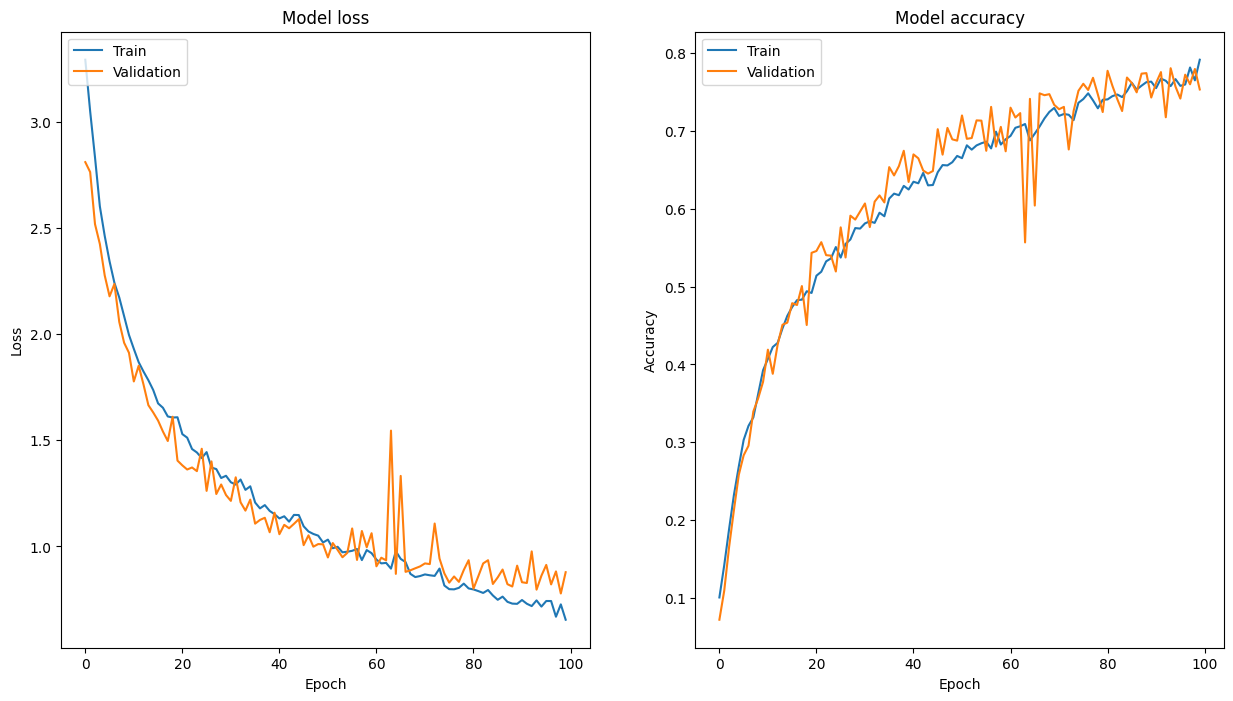

In [95]:
#First test with dropout


model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Add dropout with dropout rate of 0.5
    
    layers.Dense(15, activation='softmax')
])


model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=100, batch_size=200, verbose=2, class_weight = class_weight)

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['RegularizedDOModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

![2nd graph](image.png)


We can see that the overfitting problem is basically non existent now, we can try to increase the epochs to let the model fully converge and see if we can get better results.


Epoch 1/300
46/46 - 1s - loss: 3.2331 - accuracy: 0.1028 - val_loss: 2.8942 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 2/300
46/46 - 0s - loss: 3.0965 - accuracy: 0.1153 - val_loss: 2.8108 - val_accuracy: 0.1050 - 326ms/epoch - 7ms/step
Epoch 3/300
46/46 - 0s - loss: 2.8471 - accuracy: 0.1800 - val_loss: 2.5654 - val_accuracy: 0.1457 - 338ms/epoch - 7ms/step
Epoch 4/300
46/46 - 0s - loss: 2.6201 - accuracy: 0.2296 - val_loss: 2.4663 - val_accuracy: 0.1867 - 343ms/epoch - 7ms/step
Epoch 5/300
46/46 - 0s - loss: 2.4763 - accuracy: 0.2604 - val_loss: 2.2695 - val_accuracy: 0.2557 - 328ms/epoch - 7ms/step
Epoch 6/300
46/46 - 0s - loss: 2.3733 - accuracy: 0.2810 - val_loss: 2.1779 - val_accuracy: 0.2903 - 332ms/epoch - 7ms/step
Epoch 7/300
46/46 - 0s - loss: 2.2695 - accuracy: 0.3182 - val_loss: 2.3192 - val_accuracy: 0.2633 - 327ms/epoch - 7ms/step
Epoch 8/300
46/46 - 0s - loss: 2.2353 - accuracy: 0.3212 - val_loss: 2.1267 - val_accuracy: 0.3127 - 329ms/epoch - 7ms/step
Epoch 9/30

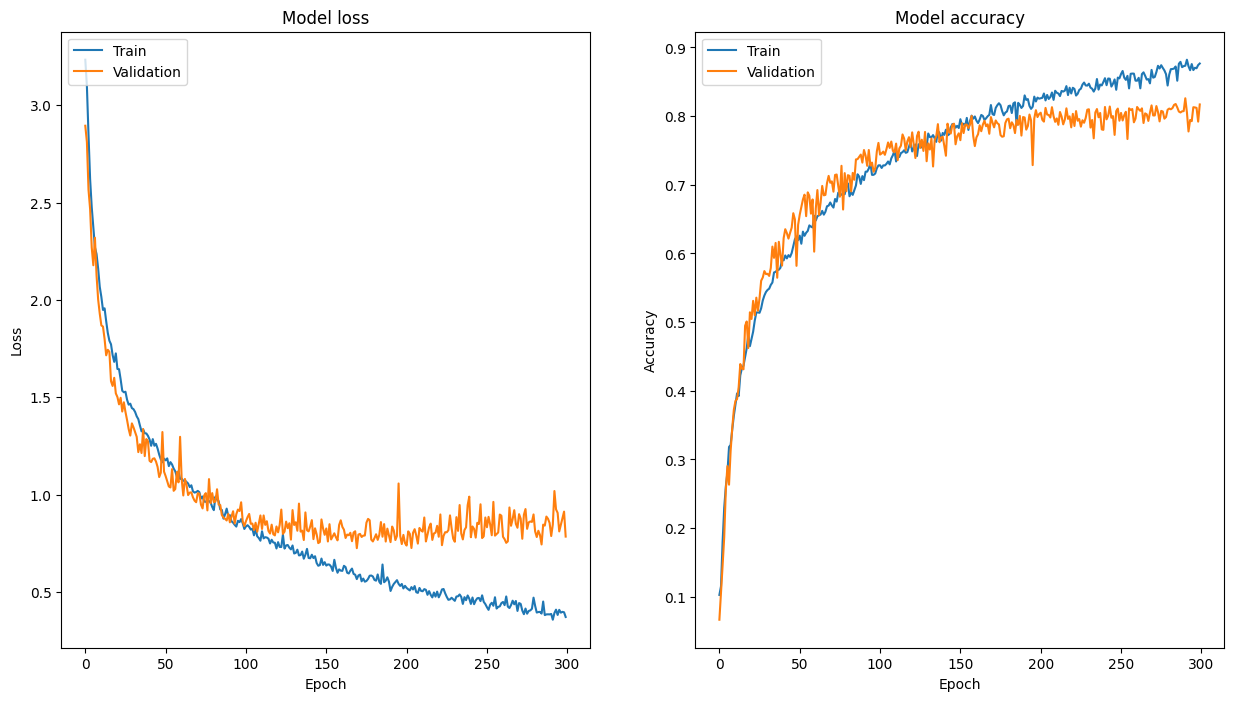

In [96]:
#Same model and other params, change epochs


model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5), 
    
    layers.Dense(15, activation='softmax')
])


model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['RegularizedDOModel2', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

![graph 3](image.png)

We can clearly see that the model stops learning and basically completely flattens out past around the 100th epoch, it is wise to either lower the learning rate of the model altogether or implement a learning rate scheduler in order to improve the performance of the model.

Epoch 1/300
46/46 - 1s - loss: 3.2313 - accuracy: 0.1030 - val_loss: 2.8960 - val_accuracy: 0.0667 - lr: 0.0010 - 934ms/epoch - 20ms/step
Epoch 2/300
46/46 - 0s - loss: 3.1081 - accuracy: 0.1205 - val_loss: 2.8547 - val_accuracy: 0.0953 - lr: 0.0010 - 332ms/epoch - 7ms/step
Epoch 3/300
46/46 - 0s - loss: 2.9456 - accuracy: 0.1657 - val_loss: 2.7591 - val_accuracy: 0.1133 - lr: 0.0010 - 336ms/epoch - 7ms/step
Epoch 4/300
46/46 - 0s - loss: 2.7380 - accuracy: 0.2056 - val_loss: 2.5181 - val_accuracy: 0.1667 - lr: 0.0010 - 332ms/epoch - 7ms/step
Epoch 5/300
46/46 - 0s - loss: 2.5837 - accuracy: 0.2419 - val_loss: 2.3355 - val_accuracy: 0.2407 - lr: 0.0010 - 320ms/epoch - 7ms/step
Epoch 6/300
46/46 - 0s - loss: 2.4442 - accuracy: 0.2719 - val_loss: 2.2423 - val_accuracy: 0.2713 - lr: 0.0010 - 328ms/epoch - 7ms/step
Epoch 7/300
46/46 - 0s - loss: 2.3497 - accuracy: 0.2964 - val_loss: 2.2627 - val_accuracy: 0.2713 - lr: 0.0010 - 324ms/epoch - 7ms/step
Epoch 8/300
46/46 - 0s - loss: 2.2661 - 

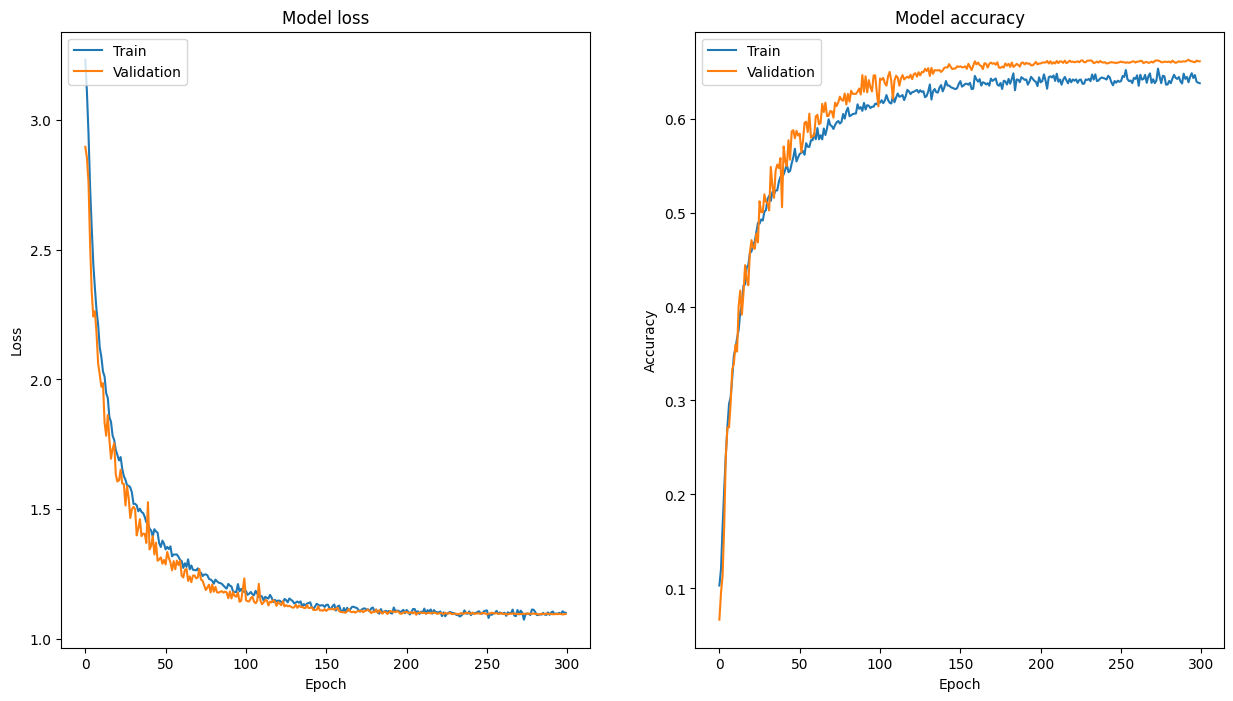

In [98]:
#try lr scheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.001 #default of adam
    decay_factor = 0.8
    epochs_drop = 10
    new_lr = initial_lr * (decay_factor ** (epoch // epochs_drop))
    return new_lr

lr_scheduler = LearningRateScheduler(lr_schedule)

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5), 
    
    layers.Dense(15, activation='softmax')
])


model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])
    
history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                          epochs=300, batch_size=200, verbose=2, class_weight=class_weight,
                          callbacks=[lr_scheduler])

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['LearningRateDecayModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]



![graph 4](image.png)

We can see that the learning rate scheduler has not improved the performance of the model, the accuracy is stll flattening out after about 100 epochs and the overall accuracy has decreased as well. Instead of using the learning rate scheduler, we can try to add more dropout layers/regularization layers to RegularizedDOModel2 (300 epoch model) and see if we can overcome the overfitting problem and get a val accuracy of over 90%.

Epoch 1/300
46/46 - 1s - loss: 3.6593 - accuracy: 0.0943 - val_loss: 3.1741 - val_accuracy: 0.0667 - 1s/epoch - 28ms/step
Epoch 2/300
46/46 - 0s - loss: 3.4177 - accuracy: 0.1077 - val_loss: 3.0852 - val_accuracy: 0.0880 - 361ms/epoch - 8ms/step
Epoch 3/300
46/46 - 0s - loss: 3.2015 - accuracy: 0.1389 - val_loss: 2.9891 - val_accuracy: 0.1057 - 362ms/epoch - 8ms/step
Epoch 4/300
46/46 - 0s - loss: 3.0358 - accuracy: 0.1594 - val_loss: 2.7985 - val_accuracy: 0.1113 - 363ms/epoch - 8ms/step
Epoch 5/300
46/46 - 0s - loss: 2.9250 - accuracy: 0.1707 - val_loss: 2.7420 - val_accuracy: 0.1347 - 365ms/epoch - 8ms/step
Epoch 6/300
46/46 - 0s - loss: 2.7886 - accuracy: 0.1981 - val_loss: 2.6511 - val_accuracy: 0.1560 - 350ms/epoch - 8ms/step
Epoch 7/300
46/46 - 0s - loss: 2.6318 - accuracy: 0.2303 - val_loss: 2.5223 - val_accuracy: 0.1757 - 358ms/epoch - 8ms/step
Epoch 8/300
46/46 - 0s - loss: 2.5300 - accuracy: 0.2510 - val_loss: 2.4651 - val_accuracy: 0.2160 - 359ms/epoch - 8ms/step
Epoch 9/30

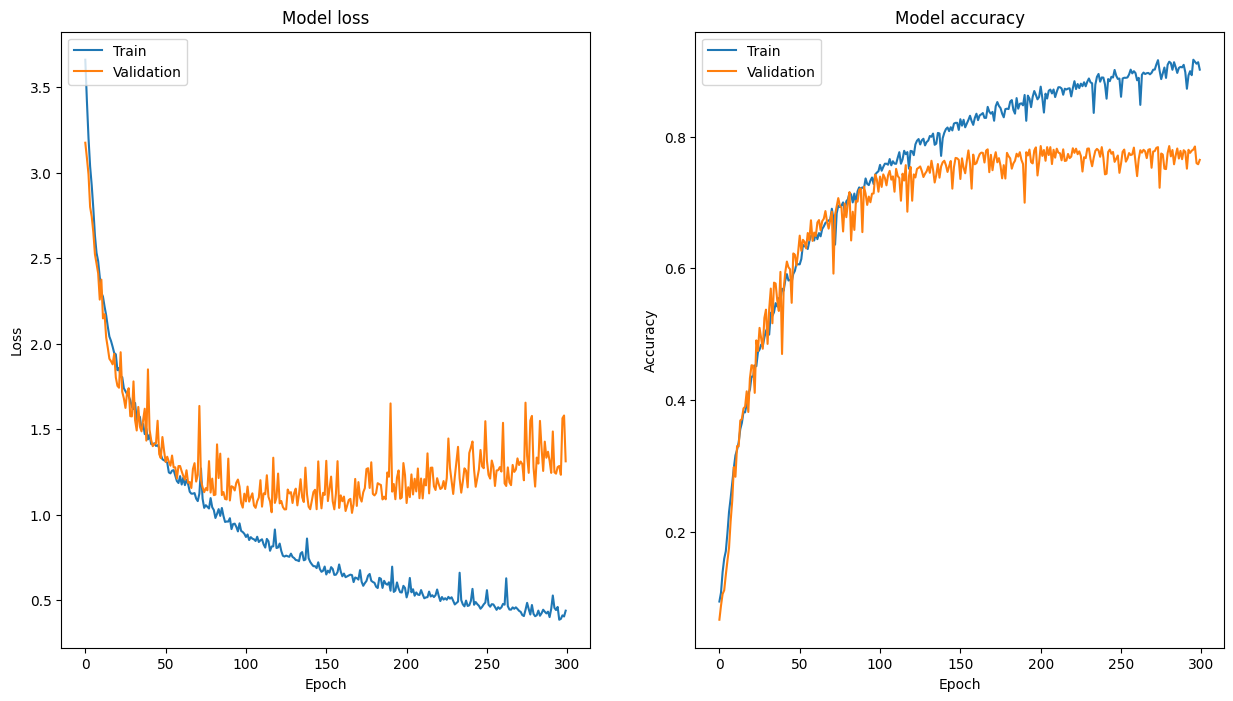

In [100]:
#Increase dropout layers and l1 regularization instead

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(15, activation='softmax')
])



model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['ExtraDORegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

![graph 5](image.png)

We can see that the model is still overfitting, and that it has actually gotten worse. Because of this i feel like i should change my direction of approach. We can try to remove some of the layers in model and see if we can get better results.

Epoch 1/300
46/46 - 1s - loss: 3.2373 - accuracy: 0.1031 - val_loss: 2.9324 - val_accuracy: 0.0667 - 938ms/epoch - 20ms/step
Epoch 2/300
46/46 - 0s - loss: 3.0938 - accuracy: 0.1277 - val_loss: 2.8005 - val_accuracy: 0.1053 - 341ms/epoch - 7ms/step
Epoch 3/300
46/46 - 0s - loss: 2.9323 - accuracy: 0.1568 - val_loss: 2.7371 - val_accuracy: 0.1150 - 337ms/epoch - 7ms/step
Epoch 4/300
46/46 - 0s - loss: 2.7428 - accuracy: 0.1850 - val_loss: 2.5605 - val_accuracy: 0.1560 - 344ms/epoch - 7ms/step
Epoch 5/300
46/46 - 0s - loss: 2.5909 - accuracy: 0.2245 - val_loss: 2.4097 - val_accuracy: 0.1963 - 335ms/epoch - 7ms/step
Epoch 6/300
46/46 - 0s - loss: 2.4899 - accuracy: 0.2513 - val_loss: 2.3734 - val_accuracy: 0.2237 - 336ms/epoch - 7ms/step
Epoch 7/300
46/46 - 0s - loss: 2.4123 - accuracy: 0.2729 - val_loss: 2.4279 - val_accuracy: 0.2187 - 324ms/epoch - 7ms/step
Epoch 8/300
46/46 - 0s - loss: 2.3162 - accuracy: 0.2866 - val_loss: 2.2298 - val_accuracy: 0.2513 - 327ms/epoch - 7ms/step
Epoch 9

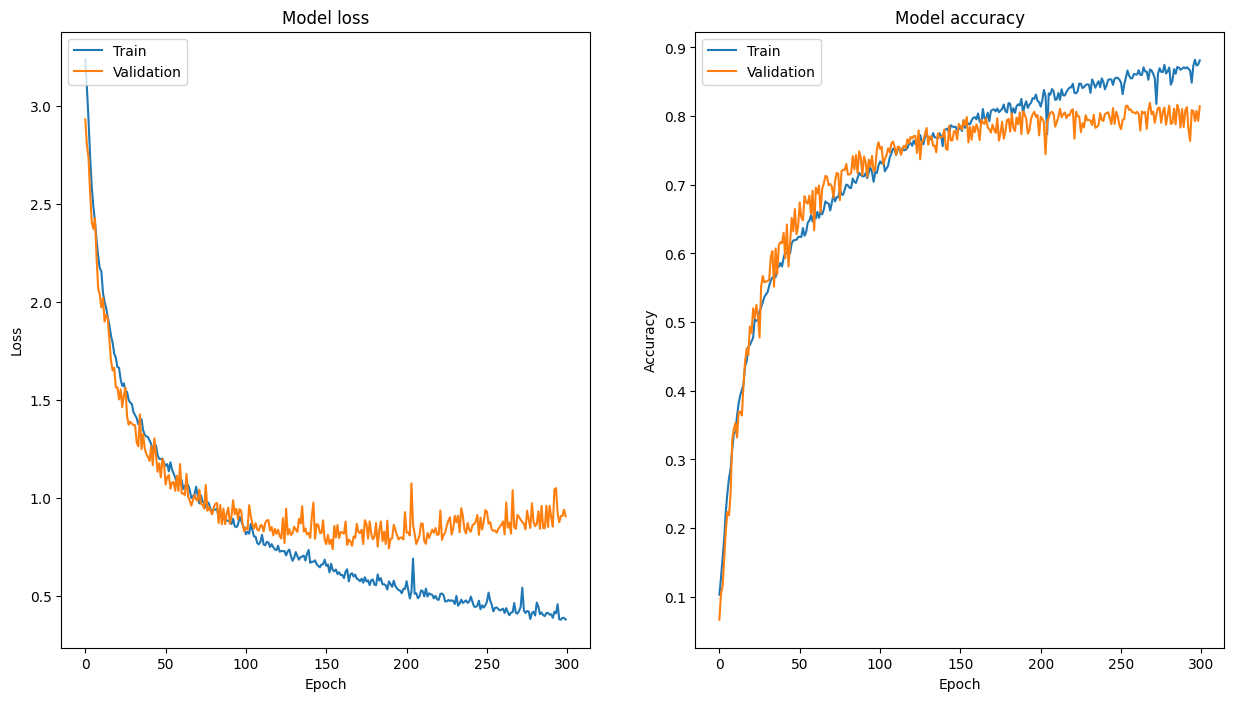

In [108]:
#Decrease layers

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(15, activation='softmax')
])



model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['ExtraDORegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

![Graph 6](image.png)
We can see that the performance has improved ever so slightly, we can consider adding dropouts to the con layers to close up the overfitting gap. Batch normalization might also be a good idea to try and increase the convergence speed of the model.

Epoch 1/300
46/46 - 1s - loss: 3.2478 - accuracy: 0.1060 - val_loss: 2.8393 - val_accuracy: 0.0667 - 1s/epoch - 22ms/step
Epoch 2/300
46/46 - 0s - loss: 3.1241 - accuracy: 0.1302 - val_loss: 2.7912 - val_accuracy: 0.1093 - 361ms/epoch - 8ms/step
Epoch 3/300
46/46 - 0s - loss: 2.9510 - accuracy: 0.1711 - val_loss: 2.6805 - val_accuracy: 0.1223 - 360ms/epoch - 8ms/step
Epoch 4/300
46/46 - 0s - loss: 2.7718 - accuracy: 0.2053 - val_loss: 2.5357 - val_accuracy: 0.1667 - 363ms/epoch - 8ms/step
Epoch 5/300
46/46 - 0s - loss: 2.6003 - accuracy: 0.2375 - val_loss: 2.3254 - val_accuracy: 0.2680 - 363ms/epoch - 8ms/step
Epoch 6/300
46/46 - 0s - loss: 2.4684 - accuracy: 0.2720 - val_loss: 2.2727 - val_accuracy: 0.2770 - 358ms/epoch - 8ms/step
Epoch 7/300
46/46 - 0s - loss: 2.3567 - accuracy: 0.2887 - val_loss: 2.2471 - val_accuracy: 0.2843 - 354ms/epoch - 8ms/step
Epoch 8/300
46/46 - 0s - loss: 2.3020 - accuracy: 0.3060 - val_loss: 2.0965 - val_accuracy: 0.3270 - 354ms/epoch - 8ms/step
Epoch 9/30

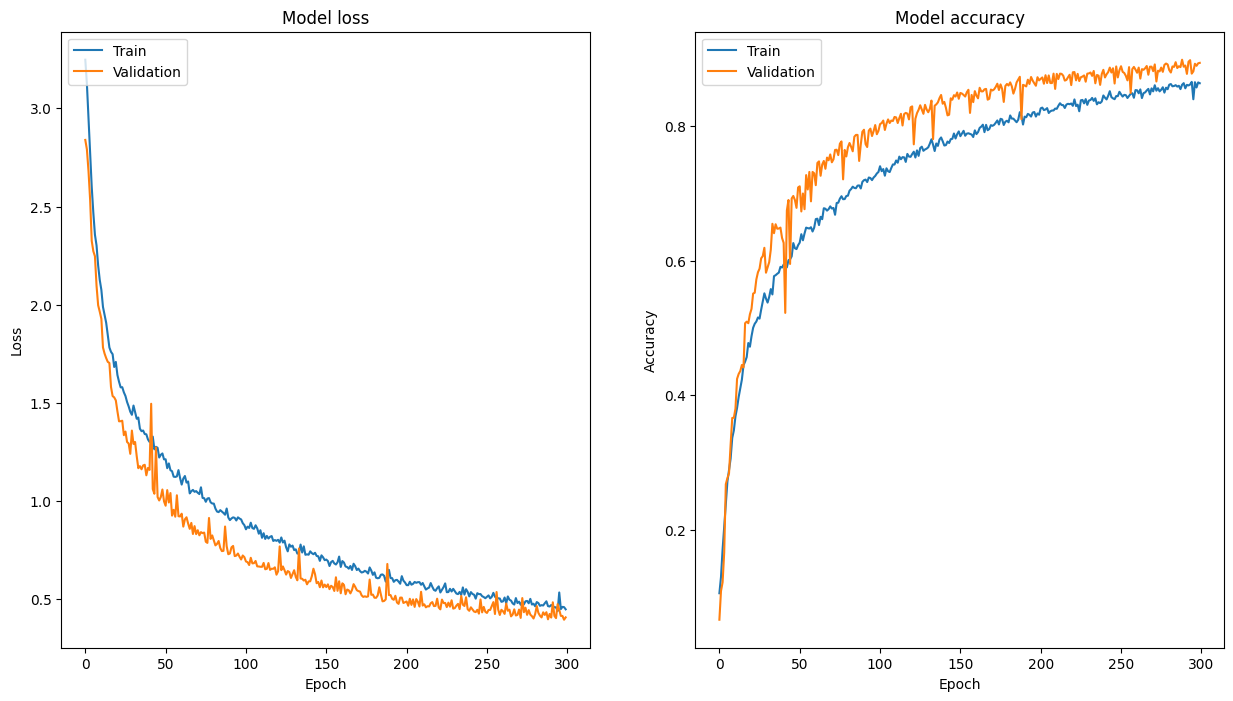

In [109]:
#Increase dropout

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(15, activation='softmax')
])



model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['ExtraDORegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

![Graph 7](image.png)

We can see that the model's performance now is excellent, we can see that near the end of the 300 epochs, there is still some sort of increase in accuracy, we can try to increase the epochs to 500 and see if we can get better results. However this is not a good idea as the runtime will increase by a lot for a small increase in accuracy, instead we can try to implement batch normalization for quicker convergence.

Epoch 1/300
46/46 - 1s - loss: 3.5293 - accuracy: 0.1715 - val_loss: 2.8805 - val_accuracy: 0.0667 - 1s/epoch - 25ms/step
Epoch 2/300
46/46 - 0s - loss: 2.7241 - accuracy: 0.2704 - val_loss: 2.9545 - val_accuracy: 0.0667 - 385ms/epoch - 8ms/step
Epoch 3/300
46/46 - 0s - loss: 2.4195 - accuracy: 0.3199 - val_loss: 3.1125 - val_accuracy: 0.0693 - 382ms/epoch - 8ms/step
Epoch 4/300
46/46 - 0s - loss: 2.2138 - accuracy: 0.3673 - val_loss: 3.2413 - val_accuracy: 0.0677 - 381ms/epoch - 8ms/step
Epoch 5/300
46/46 - 0s - loss: 2.0723 - accuracy: 0.3958 - val_loss: 4.1789 - val_accuracy: 0.0667 - 379ms/epoch - 8ms/step
Epoch 6/300
46/46 - 0s - loss: 1.9447 - accuracy: 0.4248 - val_loss: 4.7071 - val_accuracy: 0.0667 - 380ms/epoch - 8ms/step
Epoch 7/300
46/46 - 0s - loss: 1.8463 - accuracy: 0.4504 - val_loss: 4.9230 - val_accuracy: 0.0903 - 383ms/epoch - 8ms/step
Epoch 8/300
46/46 - 0s - loss: 1.7667 - accuracy: 0.4773 - val_loss: 5.2017 - val_accuracy: 0.0960 - 384ms/epoch - 8ms/step
Epoch 9/30

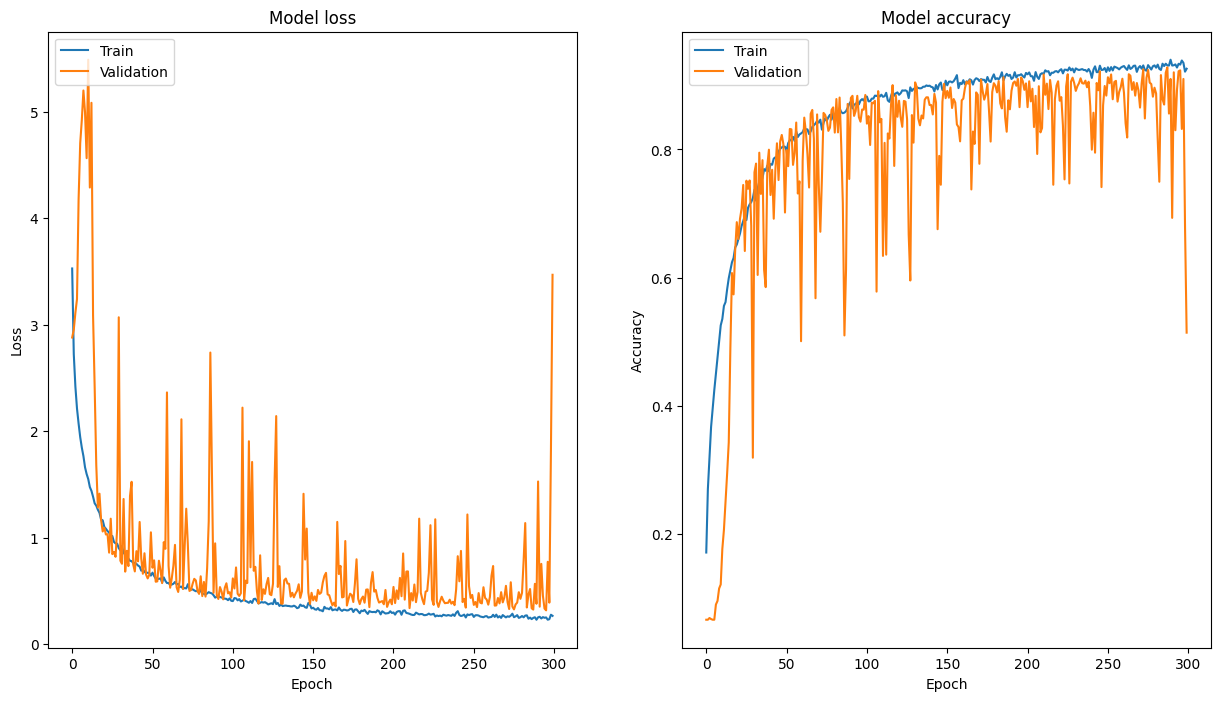

In [110]:
#Batch normalization

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(15, activation='softmax')
])



model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['ExtraDORegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

#### Data Augmentation

**What is Data Augmentation?**

Data augmentation is a technique widely used in machine learning and computer vision to artificially increase the diversity of a training dataset by applying various transformations to the existing data. The goal is to create new variations of the original images while preserving their semantic content. This approach is particularly useful in image classification tasks.

**How Does Data Augmentation Work?**

Data augmentation involves applying a set of image transformations to the training data, effectively creating new instances that are variations of the original samples. Common transformations include:

- **Rotation:** Rotating the image by a certain angle.
- **Flip:** Flipping the image horizontally or vertically.
- **Zoom:** Zooming in or out of the image.
- **Translation:** Shifting the image horizontally or vertically.
- **Brightness and Contrast Adjustment:** Changing the brightness and contrast levels.

By introducing these variations, the model becomes more robust and generalizes better to unseen data. Data augmentation helps prevent overfitting by exposing the model to a more diverse range of input patterns during training.

**Why Use Data Augmentation?**

1. **Increased Dataset Size:** Data augmentation effectively expands the training dataset, providing the model with more examples to learn from.
2. **Improved Generalization:** The augmented data exposes the model to a broader range of scenarios, improving its ability to generalize to unseen variations in the test set.
3. **Reduced Overfitting:** By presenting the model with diverse examples, data augmentation helps prevent overfitting and enhances the model's ability to handle real-world variations.


In [38]:
def augmentor(x_batch):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    x_batch_augmented = datagen.flow(x_batch, shuffle=False).next()

    
    return x_batch_augmented

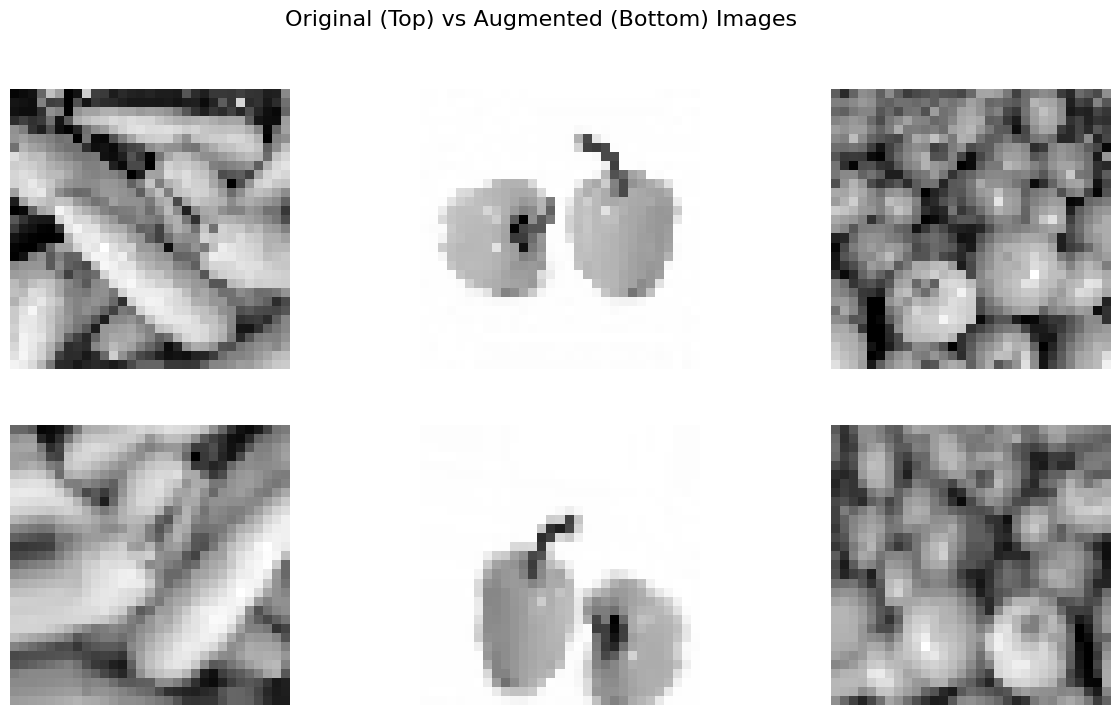

In [39]:
# Test the function on our 31x31 images
x_batch = X_train31[:3]
x_batch_augmented = augmentor(x_batch)

# Print the original and augmented images
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original Images
for i in range(3):
    ax = axes[0, i]
    ax.imshow(x_batch[i].reshape(31, 31), cmap='gray')
    ax.axis('off')

# Augmented Images
for i in range(3):
    ax = axes[1, i]
    ax.imshow(x_batch_augmented[i].reshape(31, 31), cmap='gray')
    ax.axis('off')

fig.suptitle('Original (Top) vs Augmented (Bottom) Images', fontsize=16)
plt.show()


## Improved Model

Using the LeNet Model as the base architecture, I've added several enhancements to boost its capacity for learning patterns in the data. These modifications include the data augmentation techniques, rescaling, dropout regularization, batch normalization, and an increase in the number of filters in the convolutional layers. 


### Evaluation

As we can see the model

In [41]:
def LeNetPrime(input_shape, num_classes = 15, dropout_rate = 0.5, rotate = 0.1, zoom = 0.1):
    model = Sequential()

    # Data Augmentation
    model.add(layers.RandomFlip("horizontal", input_shape=(input_shape, input_shape, 1)))
    model.add(layers.RandomRotation(0.1))
    model.add(layers.RandomZoom(0.1))

    # Convolutional Layer 1
    model.add(Conv2D(6, (5, 5), activation='tanh'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))  # Adjust the dropout rate as needed

    # Convolutional Layer 2
    model.add(Conv2D(16, (5, 5), activation='tanh'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate)) 
    # Flatten the output before the fully connected layers
    model.add(Flatten())

    # Fully Connected Layer 1
    model.add(Dense(120, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate))  # Adjust the dropout rate as needed

    # Fully Connected Layer 2
    model.add(Dense(84, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate))  # Adjust the dropout rate as needed

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [42]:
model = LeNetPrime(31)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=0)

history = model.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=30, batch_size=32, verbose=2, class_weight=class_weight,
                    callbacks=[model_checkpoint])

Epoch 1/30
283/283 - 92s - loss: 5.5827 - accuracy: 0.1391 - val_loss: 4.6422 - val_accuracy: 0.1130 - 92s/epoch - 325ms/step
Epoch 2/30


KeyboardInterrupt: 

In [ ]:
model.load_weights('best_model.h5')
scores = model.evaluate(X_val128, validation_labels, verbose=2)
print("Validation Accuracy: %.2f%%" % (scores[1] * 100))

plot_history(history)

df128.loc[len(df128)] = ['LeNetImproved', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]
print("Baseline Error: %.2f%%" % (100 - scores[1] * 100))

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\p2214535\AppData\Local\Temp\ipykernel_14780\1099761129.py", line 2, in <module>
      scores = model.evaluate(X_val128, validation_labels, verbose=2)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1667, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[1682,15] labels_size=[32,15]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_96312]

## Model Evaluation

Now that we have introduced many more "improvements", the performance of the model has not necessarily increased, however we should not be worried as well can always tune the model

In [ ]:
import random
columns = ['dropout', 'learning_rate', 'rotate', 'zoom', 'best_accuracy', 'best_lr']
results_df = pd.DataFrame(columns=columns)

tunable = {
    "dropout": (0.1, 0.9, "float"),
    "learning_rate": (0.00001, 0.1, "float"),
    "rotate": (0.1, 0.9, "float"),
    "zoom": (0.1, 0.9, "float"),
}

for o in range(1000000):
    print('Generating New Parameters')
    params = dict()
    for key in tunable.keys():
        if tunable[key][1] == "str":
            params[key] = random.choice(tunable[key][0])
        elif tunable[key][2] == "int":
            params[key] = random.randrange(tunable[key][0], tunable[key][1])
        elif tunable[key][2] == "float":
            params[key] = random.uniform(tunable[key][0], tunable[key][1])

    print('Evaluating New Parameters')
    print(params)
    model = LeNetPrime(31, dropout_rate=params['dropout'], rotate=params['rotate'])
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model_checkpoint = ModelCheckpoint('best_model2cp.h5', monitor='val_accuracy', save_best_only=True,
                                       save_weights_only=True, mode='max', verbose=0)
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0)
    csv_logger = CSVLogger('training31.log')
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.2, patience=10, mode='max', verbose=1)

    history = model.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                        epochs=500, batch_size=32, verbose=2, class_weight=class_weight,
                        callbacks=[model_checkpoint, csv_logger, early_stopping])

    if o == 0:
        best_accuracy = np.max(history.history['val_accuracy'])
        best_lr = params['learning_rate']
    # Track the best accuracy and corresponding learning rate
    if np.max(history.history['val_accuracy']) > best_accuracy:
        best_accuracy = np.max(history.history['val_accuracy'])
        best_lr = params['learning_rate']
        model.save('best_model2.h5')
        if best_accuracy > 0.9:
            break

    scores = model.evaluate(X_val31, validation_labels, verbose=2)

    # Append the results to the DataFrame
    new_row = pd.DataFrame({
        'dropout': [params['dropout']],
        'learning_rate': [params['learning_rate']],
        'rotate': [params['rotate']],
        'zoom': [params['zoom']],
        'best_accuracy': [best_accuracy],
        'best_lr': [best_lr]
    })

    # Concatenate the new row to the existing DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Print the best accuracy and corresponding learning rate
print(f"Best Validation Accuracy: {best_accuracy} with Learning Rate: {best_lr}")

# Display the results DataFrame
print(results_df)


In [ ]:
model.load_weights('best_model2.h5')
scores = model.evaluate(X_val31, validation_labels, verbose=2)
print("Validation Accuracy: %.2f%%" % (scores[1] * 100))

plot_history(history)

df31.loc[len(df31)] = ['LeNetImproved', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]
print("Baseline Error: %.2f%%" % (100 - scores[1] * 100))

In [ ]:
# # Define the number of folds for cross-validation
# num_folds = 5
# input_shape = 31  # Adjust as needed

# # Create K-Fold cross-validation splits
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# loss_history = []

# for train_index, test_index in kf.split(train31_images):
#     train_x, test_x = train31_images[train_index], train31_images[test_index]
#     train_y, test_y = train31_labels[train_index], train31_labels[test_index]

#     model = Lenet(input_shape)

#     # Train the model
#     history = model.fit(train_x, train_y, validation_data=(test_x, test_y),
#                         epochs=100, batch_size=200, verbose=2)
    
#     loss_history.append(history)

# # Calculate and print the mean baseline error
# mean_baseline_error = 100 - np.mean([history.history['val_accuracy'][-1] * 100 for history in loss_history])
# print("Mean Baseline Error: %.2f%%" % mean_baseline_error)

# # Plot the training loss for each fold
# for i, history in enumerate(loss_history):
#     plt.plot(np.arange(1, 101), history.history['loss'], label=f"Fold {i + 1}")

# plt.xlabel("Epoch")
# plt.ylabel("Training Loss")
# plt.legend()
# plt.show()